# Multi-armed bandit problem
This is a classical reinforcement learning problem where your main goal is to maximize your **expected total reward**. <br />
Each action has an expected reward called **action-value**. <br />
We can naively calculate this value by taking the average reward of that action.

Formally: <br />
$ Q_t(a) = \frac{R_1 + R_2 + \dots + R_{K_a}}{K_a}$

By the law of the large numbers, as $K_a \rightarrow \infty$, this estimate approaches the true distribution. <br />
$ \lim_{K_a \rightarrow \infty} Q_(a) = q*(a) $

This method is called sample-average which will be demonstrated in the following...

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils.bandit import *

## Sample-average
Here we're simulating a single slot machine with a stationary distribution, i.e., the distribution doesn't change over the time. <br />
So, we'll be pulling the slot machine $n$ times and finally checking the expected reward.

In [2]:
np.random.seed(42)   # for reproducibility
bandit = Bandit(1/3) # assuming a stationary distribution

time_steps = [100, 500, 1000, 5000, 10000, 1000000]

for time_step in time_steps:
    rewards = []
    for _ in range(time_step):
        r = bandit.pull()
        rewards.append(r)
    
    expected_reward = np.mean(rewards)
    print(f'Timesteps: {time_step:9} - Q(a): {expected_reward:.4f} | MAE: {np.abs(expected_reward - bandit.p):.4f}')

Timesteps:       100 - Q(a): 0.4100 | MAE: 0.0767
Timesteps:       500 - Q(a): 0.3220 | MAE: 0.0113
Timesteps:      1000 - Q(a): 0.3370 | MAE: 0.0037
Timesteps:      5000 - Q(a): 0.3354 | MAE: 0.0021
Timesteps:     10000 - Q(a): 0.3357 | MAE: 0.0024
Timesteps:   1000000 - Q(a): 0.3330 | MAE: 0.0004


Here we can see that as the timesteps increase, more it approaches the true distribution. <br />
We can see it by checking the Mean Abslute Error (MAE) used to measure the error.

This approache is simple, however it isn't the best one. <br />
Notice that we have to store all the rewards over the run, consequentely memory and computational requirements grow over the time.

## Incremental implementation
So, how can we improve the algorithm to estimate the **action-value**? <br />
We can change the formula such way it's incremental.

Let's say $Q_k$ is the estimate for the k<sup>th</sup> reward for a given action.

$
Q_{k+1}\ =\ \frac{R_1 + R_2 + \dots + R_k }{k} \ = \frac{1}{k} \sum_{i=1}^{k} R_i \\
\ \ \ \ \ \ \ \ =\ \frac{1}{k} \bigg(R_k + \sum_{i=1}^{k-1} R_i \bigg)
$

<br />
Now we can substitute the following term $\sum_{i=1}^{k-1} R_i$ by $Q_k \times (k-1)$, because:

$
Q_{k}\ =\ \frac{1}{k-1} \sum_{i=1}^{k-1} R_i \\
\sum_{i=1}^{k-1} R_i = Q_k \times \big(k-1\big)
$

<br />
And we can finally arrange the terms and deal with the problem in an elegant manner.

$
Q_{k+1}\ =\ \frac{1}{k} \bigg(R_k + \sum_{i=1}^{k-1} R_i \bigg) \\
\ \ \ \ \ \ \ \ =\ \frac{1}{k} \bigg(R_k + Q_k \times \big(k-1\big) \bigg) \\
\ \ \ \ \ \ \ \ =\ \frac{1}{k} \bigg(R_k + k \times Q_k - Q_k \bigg) \\
\ \ \ \ \ \ \ \ =\ Q_k + \frac{1}{k} \bigg(R_k - Q_k \bigg) \\
$

Now, let's try it out...

In [3]:
bandit = Bandit(1/3) # assuming a stationary distribution

time_step = 10000

Q = .0
k = 1
for _ in range(time_step):
    r = bandit.pull()
    
    Q = Q + 1./k * (r - Q)
    k += 1

print(f'Timesteps: {time_step:9} - Q(a): {Q:.4f} | MAE: {np.abs(Q - bandit.p):.4f}')

Timesteps:     10000 - Q(a): 0.3356 | MAE: 0.0023


This is an awesome approach! <br />
Now we only store the current expected reward and k, and it requires a small computation for each new reward.

The following line is the update rule.
```python
Q = Q + 1./k * (r - Q)
```

Formally: <br />
$ NewEstimate = OldEstimate + StepSize \bigg( Target - OldEstimate \bigg) $

This expression $(Target - OldEstimate) $ is the error of the estimate. <br />
It's like a gradient descent where we take a small step toward the target.

## Exploitation x Exploration Dilemma
Until now, we dealt with one-armed bandit. However, if there exists $n$ slot machines, which one should we choose? <br />
In order to maximize the expected total reward, you should select the actions that have the highest **action-value**. <br />
This kind of actions is called **greedy actions**.

$
a* =
\underset{a}{\operatorname{argmax}} Q(a)
$

We can say you're **exploiting** your current knowledge if you select the **greedy actions**. But, since we have zero knowledge about the slot machines, we need to **explore** our choices in order to aquire some knowledge and improve our estimates over the time. <br />
In a short run our reward might be lower while exploring, however, in a long run it might be higher since we figured out our best choices and we can exploit them.

So, when should we explore and when should we exploit? <br />
There is a near greedy approach called $\epsilon$-greedy method. <br />
With a probability of $1-\epsilon$, we'll be choosing the **greedy action**, otherwise we'll be acting randomly.

In [4]:
# assuming a stationary distribution
probs = [.01, .20, .30, .50, .65, .70]
bandits = Bandits(probs)

time_step = 10000

epsilon = 1.
rewards = []
Q = np.zeros(bandits.n)
k = np.ones_like(Q)
for _ in range(time_step):
    
    if np.random.random() < epsilon:
        action = np.random.choice(range(bandits.n)) # exploration
    else:
        action = np.random.choice(np.argwhere(Q==np.amax(Q)).ravel()) # exploitation
    r = bandits.pull(action)
    
    Q[action] = Q[action] + 1./k[action] * (r - Q[action])
    k[action] += 1
    rewards.append(r)
    
    epsilon = max(epsilon-.0001, .01)

print('Expected Reward')
for ix, q in enumerate(Q):
    print(f'\tBandit: {ix} - {q:.4f} - MAE: {abs(q-probs[ix]):.4f}')

Expected Reward
	Bandit: 0 - 0.0100 - MAE: 0.0000
	Bandit: 1 - 0.1981 - MAE: 0.0019
	Bandit: 2 - 0.2976 - MAE: 0.0024
	Bandit: 3 - 0.5006 - MAE: 0.0006
	Bandit: 4 - 0.6553 - MAE: 0.0053
	Bandit: 5 - 0.7078 - MAE: 0.0078


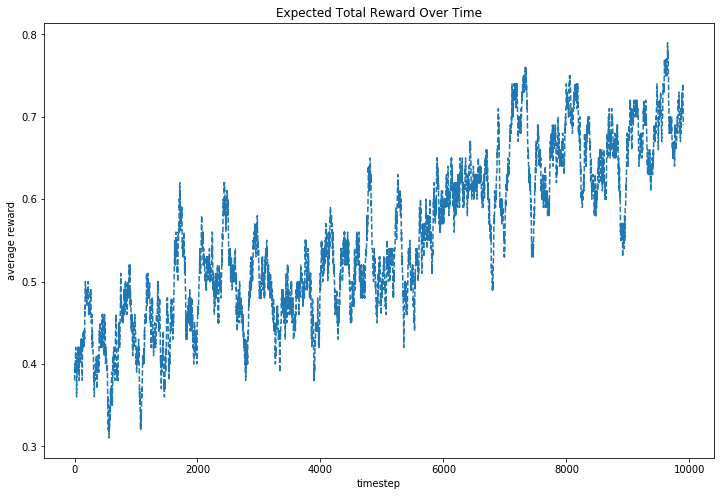

In [5]:
expected_total_reward_over_time = [np.mean(rewards[i-100:i]) for i in range(len(rewards)) if rewards[i-100:i]]

plt.figure(figsize=(12, 8))
plt.plot(expected_total_reward_over_time, '--')
plt.title('Expected Total Reward Over Time')
plt.xlabel('timestep')
plt.ylabel('average reward')
plt.show()

Finally, we can see here that our **Expected Total Reward** in the beginning is low, however it increases over the time. <br />
Thanks to $\epsilon$-greedy method, it allows us explore and search for the best options and in the end exploit them.